# Generalized Lotka Volterra: joint alternate estimation for inverse problem

TODO

**In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$**. The dynamic and initial condition losses will be the same as in the [introductory notebook](https://mia_jinns.gitlab.io/jinns/Notebooks/Tutorials/1D_Generalized_Lotka_Volterra/) but we will also **make use of available observations** and we will also **differentiate the dynamic loss with respect to the equation parameter $\theta$**.

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = \alpha_iu_i(t)
-\sum_j\gamma_{j,i}u_j(t) - \beta_i\sum_{i'}u_{i'}(t), i\in\{1, 2, 3\}
$$
where $\alpha$ are the growth rates, $\gamma$ are the interactions terms and $\beta$ and the capacity terms.

We choose the time interval $I=[0,1]$ and the domain $\Omega=[-1,1]$. We denote by $\partial\Omega$ the boundary domain.

Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\text{argmin}_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\sum_{i}^{n_x}\sum_j^{n_t}\Big(u_\nu(t_j,x_i) + u_\nu(t_j,x_i)\frac{\partial}{\partial x}
          u_\nu(t_j,x_i) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t_j,x_i)\Big)^2\\
&+w_{ic}\sum_i^{nx}\Big(u_\nu(0,x_i)-(-\sin(\pi x_i))\Big)^2\\
&+w_{bc}\sum_j^{n_t}\Big[\Big(u_\nu(t_j,-1)\Big)^2+\Big(u_\nu(t_j,1)\Big)^2\Big]
\end{align*}
$$

**Note that this approach could be much more refined by working on the optimization scheme**: alternative optimizers for $\nu$ and $\theta$, pre-training for $\nu$ only, etc. This tutorial only gives a first idea on how to tackle inverse problems with **jinns**.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import jax

# from jax import config
# config.update("jax_enable_x64", True)
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

figsize = (4, 4)
plt.rcParams["figure.figsize"] = figsize

In [4]:
key = jax.random.PRNGKey(42)

## Define the equation parameters

Time domain

In [5]:
tmin = 0
tmax = 1

Tmax = 30

In [6]:
# initial conditions for each species
import numpy as onp

# N_0 = onp.array([3.0, 1.0, 4.0])
# # growth rates for each species
# growth_rates = jnp.array([0.01, 0.05, 0.04])

# # interactions
# interactions = -jnp.array([[0, 0.2, 0.1], [0.1, 0, 0.1], [0.1, 0.2, 0]])

key = jax.random.PRNGKey(2)
key, subkey = jax.random.split(key)

Ns = 10
A = jax.random.normal(subkey, shape=(Ns,Ns))*1e-2
key, subkey = jax.random.split(key)
dA = jnp.diag(A)
key, subkey = jax.random.split(key)
A *= jax.random.bernoulli(subkey, p=0.4, shape=A.shape)
A = A-A.T
A = A+jnp.diag(-jnp.abs(dA))
interactions = A
key, subkey = jax.random.split(key)
growth_rates = jnp.abs(jax.random.normal(subkey, shape=(Ns,)))*1e-1
key, subkey = jax.random.split(key)
N_0 = jax.random.uniform(subkey, shape=(Ns,)) * 10



In [7]:
key, subkey = jax.random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=500,
    tmin=tmin,
    tmax=tmax,
    method="uniform",
    temporal_batch_size=None,
)

ts = val_data.times.sort(axis=0).squeeze()
# NOTE parfois np.any(np.diff(ts) <= 0) qui provoque une erreur dans solve_ivp
# mais on a toujours np.any(np.diff(ts) < 0)

## Observations

We use observations obtained from a run of a ground truth solver/

In [8]:
import numpy as np
from scipy.integrate import solve_ivp


def GLV_RHS(t, y, theta):
    """
    This equation is given in log space. That means the input y is the logarithm of the population density
    """
    alpha, gamma = theta
    return (alpha + (gamma @ jnp.exp(y).reshape((gamma.shape[0], 1))).squeeze()).ravel()


# Define name bacteria
names = ["N1", "N2", "N3"]
N = len(names)

# Define model parameters
eq_params = (growth_rates, interactions)

# Define initial bacterial populations
y0 = N_0

# Define time points
Tmax = 30
t = ts * Tmax

############################

y0_log = np.log(y0)
sol_log = solve_ivp(
    fun=GLV_RHS,
    y0=y0_log,
    t_span=(0, Tmax),
    t_eval=ts * Tmax,
    args=(eq_params,),
)
y = np.exp(sol_log.y).T

In [9]:
val_data.times.shape

(500, 1)

In [10]:
np.any(np.diff(ts) <= 0)

np.False_

In [11]:
n = 500
subsample_size = 10
subsample = jnp.arange(n)
subsample = subsample[:: int(n / (subsample_size - 1))]
subsample = jnp.append(subsample[:-1], n - 1)
t_subsample = ts[subsample]
log_obs_subsample = jnp.log(y[subsample])

__Optionally blur the observed values__

In [12]:
noise_level = 0.1

key, subkey = jax.random.split(key)
noise = noise_level * jax.random.normal(subkey, shape=log_obs_subsample.shape)
log_obs_subsample_noisy = log_obs_subsample + noise
# obs_subsample_noisy = jnp.where(obs_subsample_noisy < 1e-6, 1e-6, obs_subsample_noisy)

**Visualize the noisy observations**

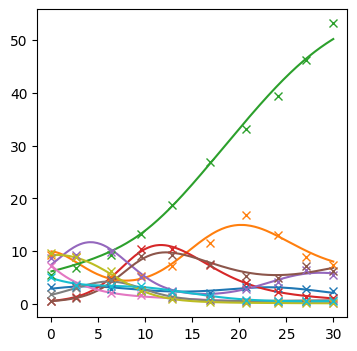

In [13]:
plt.plot(ts * Tmax, y)
plt.gca().set_prop_cycle(None)
plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
plt.show()

## Estimate the solution and the parameters of the GLV system

*Define the domain and the associated data generator*

In [14]:
key, subkey = jax.random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=5000,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=None,
    method="uniform",
)

*Define the data generator for the observations*

In [15]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    key=subkey,
    obs_batch_size=None,
    observed_pinn_in=t_subsample,
    observed_values=log_obs_subsample_noisy,
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`.

In [16]:
N_neurons = 7 * Ns
eqx_list = (
    (eqx.nn.Linear, 1, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, Ns),
)
key, subkey = jax.random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

*Define the jinns parameter object. **Equation parameters are initialized to 0 everywhere.***

In [17]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "g": jnp.zeros_like(growth_rates),
        "i": jnp.zeros_like(interactions),
    },
)

*Define the loss weights*

In [18]:
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=1.0, initial_condition=1.0, observations=1.0
)

*Define the dynamic loss term*

In [19]:
class GLV_loss(jinns.loss.ODE):
    def equation(self, t, u, params):
        """
        This equation is given in log, this means that u is the log of the population density
        """
        udt = jax.jacfwd(lambda x: u(x, params))(t).squeeze()
        f = udt - self.Tmax * GLV_RHS(
            t, u(t, params), (params.eq_params.g, params.eq_params.i)
        )
        return f


dynamic_loss = GLV_loss(Tmax=Tmax)

*Define how to differentiate each term of the loss* Note that the main `params` of the problem must be passed since we use the `from_str()` constructor

In [20]:
derivative_keys = jinns.parameters.DerivativeKeysODE.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params=True,
        eq_params={
            "g": jax.tree.map(lambda _: True, init_params.eq_params.g),
            "i": jax.tree.map(lambda _: True, init_params.eq_params.i),
        },
    ),
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params,
)

*Define the ODE PINN losses*

In [21]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
    # update_weight_method="soft_adapt",
)

### Joint alternate training with `jinns.solve_alternate()`

**Pretraining**

*Up to this point, the content is the same as in the joint vanilla estimation tutorial in the Burgers case. But here we diverge. We will need to construct the object needed for the `jinns.solve_alternate()` call. And, first of all, we will start with a PINN pretraining of observations only. One argument in favor of such pretraining is that we will start the alternate procedure with a number of iterations on $\theta$ only: to avoid a collapse to $0$, it would be useful for the PINN to be pretrained.*

In [22]:
pretrain_loss = jinns.loss.LossODE(
    u=u,
    loss_weights=jinns.loss.LossWeightsODE(
        dyn_loss=0.0,
        initial_condition=1.0,
        observations=1.0,  # ZERO to block gradients from dynamic loss
    ),
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

In [23]:
pretrain_tx = optax.adam(learning_rate=1e-3)

key, subkey = jax.random.split(key)
print("PINN pretraining with observations only")
(
    pretrain_params,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    _,
    stored_loss_weight_terms,
    _,
    _,
    _,
    _,
) = jinns.solve(
    n_iter=10000,
    init_params=init_params,
    data=train_data,
    optimizer=pretrain_tx,
    loss=pretrain_loss,
    obs_data=obs_data,
    print_loss_every=1000,
    key=subkey,
)

PINN pretraining with observations only
Initialization time: 0.5389108657836914

Compilation took
 4.198884010314941 

[train] Iteration 0: loss value = 55.136566162109375
[train] Iteration 1000: loss value = 0.36798375844955444
[train] Iteration 2000: loss value = 0.1370231956243515
[train] Iteration 3000: loss value = 0.07719297707080841
[train] Iteration 4000: loss value = 0.05355779826641083
[train] Iteration 5000: loss value = 0.039952926337718964
[train] Iteration 6000: loss value = 0.023397261276841164
[train] Iteration 7000: loss value = 0.014951415359973907
[train] Iteration 8000: loss value = 0.011993519961833954
[train] Iteration 9000: loss value = 0.011059910990297794

Stopping main optimization loop, cause: max iteration is reached

Training took
 44.90984106063843 


Final iteration 10000: train loss value = 0.010150652378797531


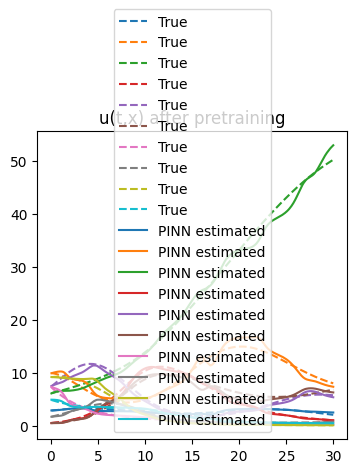

In [24]:
pretrain_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, pretrain_params)))

plt.plot(ts * Tmax, y, linestyle="--", label="True")
plt.gca().set_prop_cycle(None)
plt.plot(ts * Tmax, pretrain_u_est(ts), label="PINN estimated")
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after pretraining")
plt.legend()
plt.show()

In [25]:
assert jnp.allclose(
    total_loss_values,
    loss_by_term_dict.observations * loss_weights.observations
    + loss_by_term_dict.initial_condition * loss_weights.initial_condition,
)  # check that we only use observations and initial conditions

**Alternate joint estimation**

*We now start the alternate training*

In [26]:
from functools import partial
from typing import NamedTuple


def proj_g(p_eq_params_g):
    """ """
    p_0 = jnp.maximum(0, p_eq_params_g)

    return p_0  # eqx.tree_at(lambda pt: (pt.g), p_eq_params, (p_0))


def proj_i(p_eq_params_i):
    """ """
    p_1 = jnp.fill_diagonal(
        p_eq_params_i, jnp.minimum(0, jnp.diag(p_eq_params_i)), inplace=False
    )

    return p_1  # eqx.tree_at(lambda pt: (pt.i,), p_eq_params, (p_1,))


class EmptyState(NamedTuple):
    pass


def soft_thresholding_additive_update(
    learning_rate: optax.ScalarOrSchedule, param: str
) -> optax._src.base.GradientTransformation:
    """Soft thresholding operator, given input gradients `grads` return an
    update
    u <- - params + prox(params, grads, lr, l1reg)

    For prox_lasso, prox = max(0, params - lr * grads - lr * l1reg)

    Parameters
    ----------
    learning_rate : optax.GradientTransformation
        _description_
    l1reg : float, optional
        _description_, by default 1

    Returns
    -------
    base.GradientTransformation
    """

    def init_fn(params: optax._src.base.Params) -> EmptyState:
        return EmptyState()

    def update_fn(grads, state, params=None):
        try:
            grads_ = grads
            params_ = params
            if param == "g":
                grads = grads.eq_params.g
                params = params.eq_params.g
            elif param == "i":
                grads = grads.eq_params.i
                params = params.eq_params.i
        except:
            pass

        # new_params = jax.tree.map(lambda g, p: p - learning_rate * g, grads, params)
        # jax.debug.print("{x}", x=(param, grads))
        new_params = jax.tree.map(
            lambda u, v: v + u, params, grads
        )  # grads = previous updates

        if param == "g":
            next_x = proj_g(new_params)
        elif param == "i":
            next_x = proj_i(new_params)
        else:
            raise ValueError
        # jax.debug.print("{x}", x=(next_x.g_i[0],next_x.g_i[1],next_x.g_i[2][0]) )
        # We return prox_update - xold to be compatible with
        # with optax.apply_update(xold, additive_update) which is additive

        additive_update = jax.tree.map(lambda u, v: v - u, params, next_x)

        try:
            if param == "g":
                additive_update = eqx.tree_at(
                    lambda pt: (pt.eq_params.g,), grads_, (additive_update,)
                )
            elif param == "i":
                additive_update = eqx.tree_at(
                    lambda pt: (pt.eq_params.i,), grads_, (additive_update,)
                )
        except:
            pass

        return additive_update, EmptyState()

    return optax._src.base.GradientTransformation(init_fn, update_fn)


soft_thresholding_additive_update_g = partial(
    soft_thresholding_additive_update, param="g"
)
soft_thresholding_additive_update_i = partial(
    soft_thresholding_additive_update, param="i"
)

In [27]:
# number of alternate iterations
n_iter = 300
# number of iterations for each solver
n_iter_by_solver = jinns.parameters.Params(
    nn_params=250,
    eq_params={"g": 250, "i": 250},
)

start_learning_rate = 1e-3
nn_scheduler = optax.linear_schedule(
    init_value=start_learning_rate,
    end_value=start_learning_rate / 10,
    transition_steps=n_iter_by_solver.nn_params * n_iter,
    transition_begin=(n_iter_by_solver.nn_params * n_iter) // 2,
)
g_scheduler = optax.linear_schedule(
    init_value=start_learning_rate,
    end_value=start_learning_rate / 100,
    transition_steps=n_iter_by_solver.eq_params.g * n_iter,
    transition_begin=(n_iter_by_solver.eq_params.g * n_iter) // 2,
)
i_scheduler = optax.linear_schedule(
    init_value=start_learning_rate,
    end_value=start_learning_rate / 100,
    transition_steps=n_iter_by_solver.eq_params.i * n_iter,
    transition_begin=(n_iter_by_solver.eq_params.i * n_iter) // 2,
)

# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.chain(
        optax.scale_by_adam(),
        optax.scale_by_schedule(
            nn_scheduler
        ),  # Use the learning rate from the scheduler.
        optax.scale(-1.0),
    ),
    eq_params={
        "g": optax.chain(
            # optax.scale_by_adam(),
            # optax.scale_by_schedule(g_scheduler), # Use the learning rate from the scheduler.
            # optax.scale(-1.0),
            optax.adam(learning_rate=start_learning_rate),
            soft_thresholding_additive_update_g(learning_rate=None),
        ),
        "i": optax.chain(
            # optax.scale_by_adam(),
            # optax.scale_by_schedule(i_scheduler), # Use the learning rate from the scheduler.
            # optax.scale(-1.0),
            optax.adam(learning_rate=start_learning_rate),
            soft_thresholding_additive_update_i(learning_rate=None),
        ),
    },
)

In [28]:
(
    params_alternate,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    stored_params,
    stored_loss_weight_terms,
    _,
    _,
) = jinns.solve_alternate(
    n_iter=n_iter,
    n_iter_by_solver=n_iter_by_solver,
    init_params=pretrain_params,
    data=train_data,
    loss=loss,  # take the complete loss!
    optimizers=optimizers,
    verbose=True,
    obs_data=obs_data,
    key=subkey,
    print_loss_every=20,
)

Initialization time: 7.063873767852783
[train alternate]Iteration 0: loss value = 0.8561692833900452
[train alternate]Iteration 20: loss value = 0.09421947598457336
[train alternate]Iteration 40: loss value = 0.07157718390226364
[train alternate]Iteration 60: loss value = 0.09250080585479736
[train alternate]Iteration 80: loss value = 0.06456062942743301
[train alternate]Iteration 100: loss value = 0.05768481642007828
[train alternate]Iteration 120: loss value = 0.07012622803449631
[train alternate]Iteration 140: loss value = 0.050442710518836975
[train alternate]Iteration 160: loss value = 0.047910623252391815
[train alternate]Iteration 180: loss value = 0.04912769794464111
[train alternate]Iteration 200: loss value = 0.04189017042517662
[train alternate]Iteration 220: loss value = 0.035467591136693954
[train alternate]Iteration 240: loss value = 0.03916594758629799
[train alternate]Iteration 260: loss value = 0.038310833275318146
[train alternate]Iteration 280: loss value = 0.0369266

## Results

*Plot the loss values*

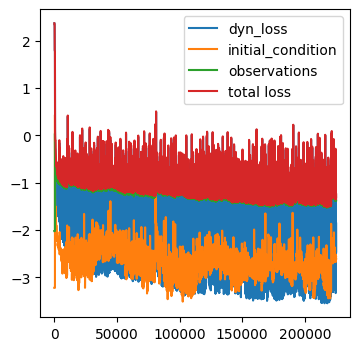

In [29]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

In [30]:
# for loss_name, weight_values in stored_loss_weight_terms.items():
#     plt.plot(weight_values, label=loss_name)
# plt.legend()
# plt.show()

*Error on parameters*

In [31]:
from jinns.parameters import EqParams
from dataclasses import fields

true_params = EqParams({"g": growth_rates, "i": interactions})

for f in fields(params_alternate.eq_params):
    p = getattr(params_alternate.eq_params, f.name)
    p_true = getattr(true_params, f.name)

    rmse = jnp.mean(
        jax.tree.reduce(  # the tree.reduce does not have an effect on carrying_capacities and growth_rates
            lambda a, b: (a + b) / 2,
            jax.tree.map(lambda p1, p2: (p1 - p2) ** 2, p, p_true),
            0,
        )
    )
    print(f.name, "\nestimated:", p, "\ntrue:", p_true, "\nError", rmse, "\n")

g 
estimated: [0.00728569 0.02046502 0.04887678 0.02777172 0.00652413 0.08104046
 0.01260021 0.00094291 0.04637031 0.01475629] 
true: [0.06126295 0.10293626 0.07563413 0.0461417  0.00226323 0.01607672
 0.00504259 0.01859241 0.04739843 0.12782332] 
Error 0.0014080368 

i 
estimated: [[-6.99418858e-02  1.47751402e-02  4.65293386e-04 -3.50374430e-02
  -4.16641682e-02  3.64835039e-02 -1.55004915e-02  4.06384952e-02
   2.99027096e-02  4.24099639e-02]
 [-8.48553851e-02 -2.24740637e-04  6.67872699e-03  1.30363861e-02
  -5.28211780e-02  9.83896200e-03  4.10923734e-02  5.45717143e-02
   3.92895080e-02 -2.29806639e-02]
 [-1.96133852e-02 -1.05256424e-03 -2.68855918e-04  7.81870726e-03
   1.03565911e-02  7.41793541e-03  7.44844973e-03  2.56160460e-03
   5.84999844e-03 -3.17810774e-02]
 [-1.42988013e-02 -1.20658809e-02  1.51303480e-03 -4.18486679e-03
  -8.50726850e-03 -1.12110442e-02 -8.06686096e-03  5.32792695e-02
   2.85030883e-02  4.62285839e-02]
 [-1.39645180e-02  2.33626161e-02 -3.19811446e-03

*Error on the curves*

In [32]:
trained_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_alternate)))

In [33]:
# Profiled error: RMSE error between the true curve and the PINN estimation
rmse_p = jnp.sum(
    jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, trained_u_est(ts))
)
print("RMSE profiled error", rmse_p)

# Reconstructed error: RMSE error between the true curve and the ground truth solver solution run
# with the system parameters estimated by jinns.solve_alternate()
rec_sol_log = solve_ivp(
    fun=GLV_RHS,
    y0=y0_log,
    t_span=(0, Tmax),
    t_eval=ts * Tmax,
    args=(
        (
            params_alternate.eq_params.g,
            params_alternate.eq_params.i,
        ),
    ),
)
rec_y = np.exp(rec_sol_log.y).T
rmse_r = jnp.sum(jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, rec_y))
print("RMSE profiled error", rmse_r)

RMSE profiled error 7.3552184
RMSE profiled error 45.418495


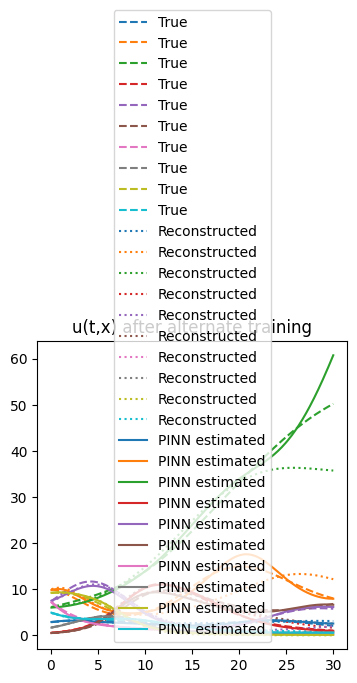

In [34]:
plt.plot(ts * Tmax, y, linestyle="--", label="True")
plt.gca().set_prop_cycle(None)
if rec_sol_log.status == 0 and not jnp.isnan(rmse_r):
    plt.plot(ts * Tmax, rec_y, linestyle="dotted", label="Reconstructed")
else:
    print(
        "Warning! Curves from scipy solver with estimated parameters are not plotted because a problem appeared in the resolution"
    )
plt.gca().set_prop_cycle(None)
plt.plot(ts * Tmax, trained_u_est(ts), label="PINN estimated")
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after alternate training")
plt.legend()
plt.show()

### Vanilla joint training with `jinns.solve()`

In [35]:
# number of alternate iterations
n_iter = 300
# number of iterations for each solver
n_iter_by_solver = jinns.parameters.Params(
    nn_params=250,
    eq_params={"g": 250, "i": 250},
)
param_labels = jinns.parameters.Params(
    nn_params="nn_adam",  # in this simple example we will use adamw for the nu
    eq_params={
        "g": "g_adam",
        "i": "i_adam",
    },  # in this simple example we will use rprop for theta
)

tx_nu_and_theta = optax.multi_transform(
    {
        "nn_adam": optax.chain(
            optax.scale_by_adam(),
            optax.scale_by_schedule(
                nn_scheduler
            ),  # Use the learning rate from the scheduler.
            optax.scale(-1.0),
        ),
        "g_adam": optax.chain(
            optax.adam(learning_rate=start_learning_rate),
            soft_thresholding_additive_update_g(learning_rate=None),
        ),
        "i_adam": optax.chain(
            optax.adam(learning_rate=start_learning_rate),
            soft_thresholding_additive_update_i(learning_rate=None),
        ),
    },  # all the keys in this dict must be found as leaves in the PyTree param_labels
    param_labels,
)

key, subkey = jax.random.split(key, 2)
n_iter_nu_and_theta = (n_iter * sum(jax.tree.leaves(n_iter_by_solver))) // (
    len(jax.tree.leaves(n_iter_by_solver))
)

In [36]:
params_vanilla, total_loss_list, loss_by_term_dict, _, _, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=pretrain_params,
        data=train_data,
        optimizer=tx_nu_and_theta,
        loss=loss,
        n_iter=n_iter_nu_and_theta,
        obs_data=obs_data,
        print_loss_every=10000,
    )
)

Initialization time: 0.3078165054321289

Compilation took
 2.740199327468872 

[train] Iteration 0: loss value = 234.8829345703125
[train] Iteration 10000: loss value = 0.062345486134290695
[train] Iteration 20000: loss value = 0.18816474080085754
[train] Iteration 30000: loss value = 0.04216042533516884
[train] Iteration 40000: loss value = 0.03514483943581581
[train] Iteration 50000: loss value = 0.03702901303768158
[train] Iteration 60000: loss value = 0.04379533231258392
[train] Iteration 70000: loss value = 0.046282604336738586

Stopping main optimization loop, cause: max iteration is reached

Training took
 342.36427092552185 


Final iteration 75000: train loss value = 0.048505909740924835


*Errors on parameters*

In [37]:
for f in fields(params_vanilla.eq_params):
    p = getattr(params_vanilla.eq_params, f.name)
    p_true = getattr(true_params, f.name)

    rmse = jnp.mean(
        jax.tree.reduce(  # the tree.reduce does not have an effect on carrying_capacities and growth_rates
            lambda a, b: (a + b) / 2,
            jax.tree.map(lambda p1, p2: (p1 - p2) ** 2, p, p_true),
            0,
        )
    )
    print(f.name, "\nestimated:", p, "\ntrue:", p_true, "\nError", rmse, "\n")

g 
estimated: [9.0946742e-05 5.2447174e-02 2.9378480e-03 2.5030097e-02 1.2637998e-02
 3.4915924e-02 8.7444896e-05 6.9914131e-05 3.2296576e-02 9.3271546e-03] 
true: [0.06126295 0.10293626 0.07563413 0.0461417  0.00226323 0.01607672
 0.00504259 0.01859241 0.04739843 0.12782332] 
Error 0.0013560603 

i 
estimated: [[-2.1068292e-02  1.0925080e-02  1.4362377e-03 -2.2379020e-02
  -4.5198288e-02  1.4249820e-02 -2.4239138e-02  5.0280370e-02
   2.9830806e-02  2.3672249e-02]
 [-6.0157396e-02 -3.3953813e-05  4.4471011e-03  1.8072823e-02
  -3.5562847e-02 -3.8753310e-03 -3.1550936e-04  1.0389282e-02
   2.7286151e-02  1.2994791e-02]
 [-9.9436268e-03  3.3329186e-04 -3.1621280e-04 -9.0242393e-04
   4.8975395e-03  1.0763258e-02  9.1932667e-04  5.2815732e-03
  -1.7443139e-03  5.0473642e-03]
 [-2.4344137e-02 -1.0365915e-02  1.0851191e-03 -4.2554731e-03
   3.2960321e-04 -1.2221421e-02 -2.0966996e-02  3.2554515e-02
   2.2989197e-02  7.1499661e-02]
 [ 7.8512300e-03  2.5160462e-02 -3.6624253e-03 -1.7527558e-

*Errors on reconstructed curves*

In [38]:
trained_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_vanilla)))

In [39]:
# Profiled error: RMSE error between the true curve and the PINN estimation
rmse_p = jnp.sum(
    jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, trained_u_est(ts))
)
print("RMSE profiled error", rmse_p)

# Reconstructed error: RMSE error between the true curve and the ground truth solver solution run
# with the system parameters estimated by jinns.solve_alternate()
rec_sol_log = solve_ivp(
    fun=GLV_RHS,
    y0=y0_log,
    t_span=(0, Tmax),
    t_eval=ts * Tmax,
    args=(
        (
            params_vanilla.eq_params.g,
            params_vanilla.eq_params.i,
        ),
    ),
)
rec_y = np.exp(rec_sol_log.y).T
rmse_r = jnp.sum(jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, rec_y))
print("RMSE profiled error", rmse_r)

RMSE profiled error 4.507358
RMSE profiled error 5.2592783


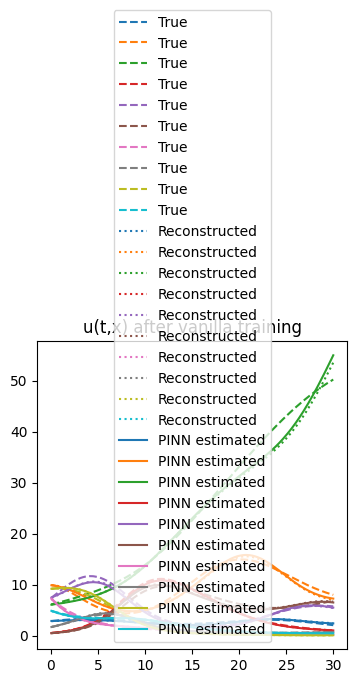

In [40]:
plt.plot(ts * Tmax, y, linestyle="--", label="True")
plt.gca().set_prop_cycle(None)
if rec_sol_log.status == 0 and not jnp.isnan(rmse_r):
    plt.plot(ts * Tmax, rec_y, linestyle="dotted", label="Reconstructed")
else:
    print(
        "Warning! Curves from scipy solver with estimated parameters are not plotted because a problem appeared in the resolution"
    )
plt.gca().set_prop_cycle(None)
plt.plot(ts * Tmax, trained_u_est(ts), label="PINN estimated")
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after vanilla training")
plt.legend()
plt.show()